In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

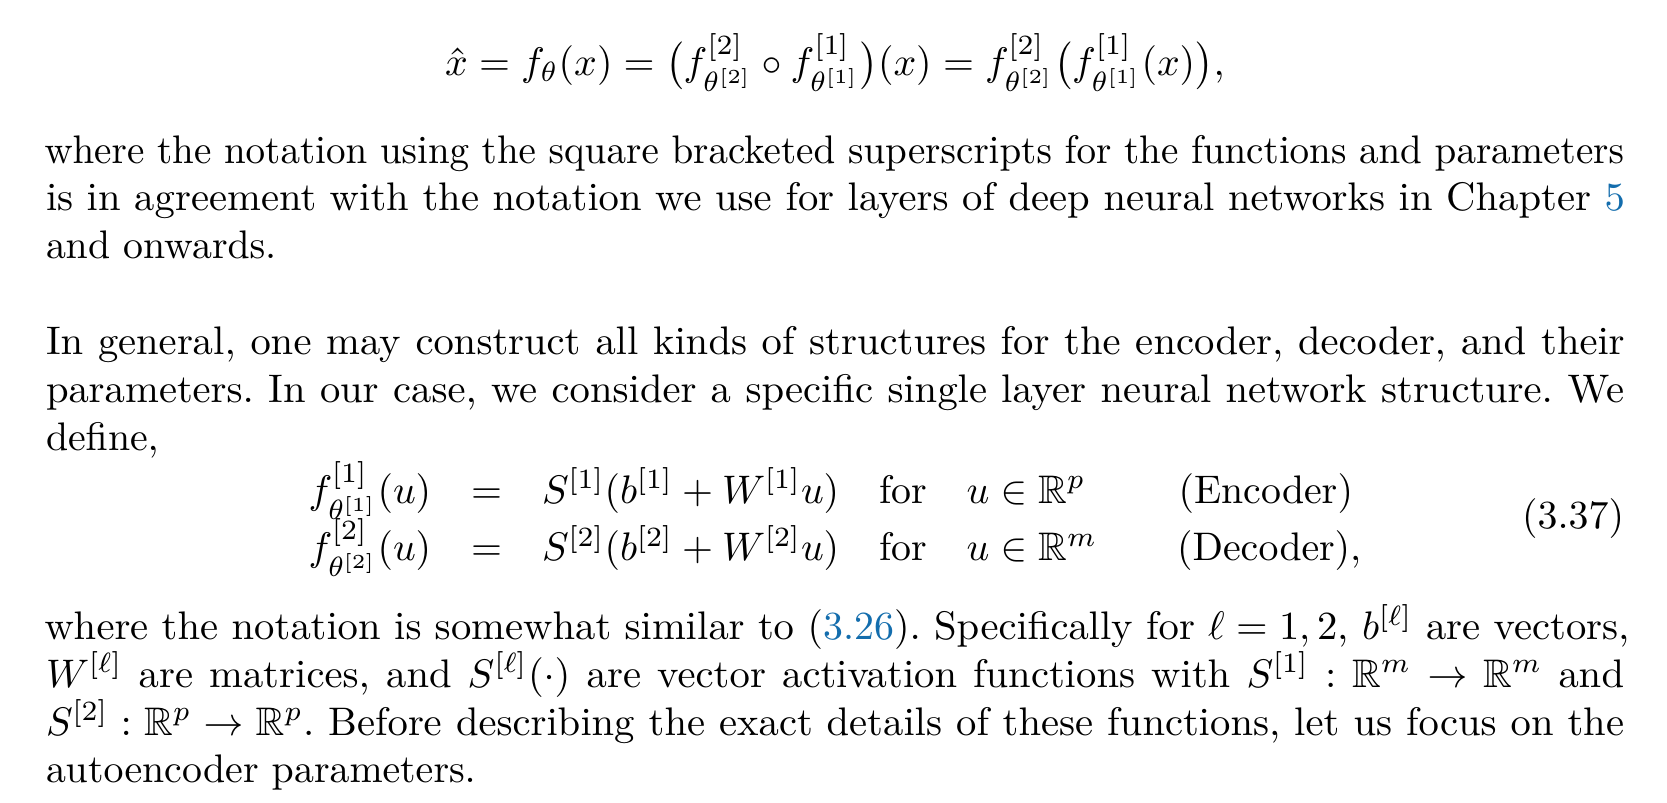

In [3]:
class AbstractAutoencoder(nn.Module):
    def __init__(self):
        super(AbstractAutoencoder, self).__init__()

    def forward(self, X):
        return self.decode(self.encode(X))

    def encode(self, X):
        raise NotImplementedError

    def decode(self, X):
        raise NotImplementedError


In [8]:
class ShallowAutoencoder(AbstractAutoencoder):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def encode(self, X):
        return self.encoder(X)
    
    def decode(self, X):
        return self.decoder(X)

In [10]:
from torchinfo import summary

model = ShallowAutoencoder(input_dim=784, hidden_dim=30, output_dim=10)
summary(model=model, input_size=(56, 1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowAutoencoder                       [56, 1, 10]               --
├─Sequential: 1-1                        [56, 1, 30]               --
│    └─Linear: 2-1                       [56, 1, 30]               23,550
│    └─Sigmoid: 2-2                      [56, 1, 30]               --
├─Sequential: 1-2                        [56, 1, 10]               --
│    └─Linear: 2-3                       [56, 1, 10]               310
│    └─Sigmoid: 2-4                      [56, 1, 10]               --
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.18
Forward/backward pass size (MB): 0.02
Params size (MB): 0.10
Estimated Total Size (MB): 0.29

In [13]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

test_transforms = train_transforms


# load MNIST dataset
trainset = datasets.MNIST(root='/home/sledge/datasets', train=True, download=True, transform= train_transforms)
testset = datasets.MNIST(root='/home/sledge/datasets', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test on grayscale image from MNIST.

In [16]:
from tqdm import tqdm

def train(model, loss_fn, optimizer, train_loader, test_loader):
    for epoch in range(5):
        model.train()
        for images, _ in (pbar := tqdm(train_loader, desc="Train")):
            images = images.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({ 'loss': loss.item() })
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, _ in (pbar := tqdm(test_loader, desc="Test")):
                images = images.to(device)
                outputs = model(images)
                test_loss = loss_fn(outputs, images)
                pbar.set_postfix({ 'loss': test_loss.item() })

In [17]:
from torch.optim import Adam

loss_fn = nn.MSELoss()
model = ShallowAutoencoder(input_dim=784, hidden_dim=30, output_dim=784).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

train(model, loss_fn, optimizer, train_loader, test_loader)

Test: 100%|██████████| 313/313 [00:02<00:00, 148.35it/s, loss=0.0296]


Reconstruction

Reconstruct:   0%|          | 0/313 [00:00<?, ?it/s]

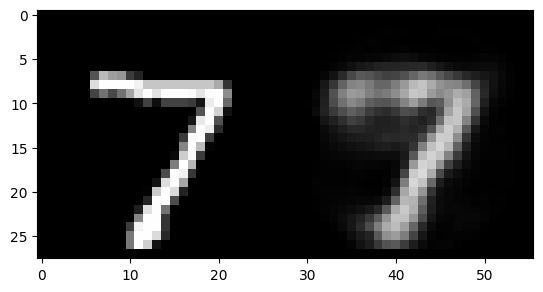

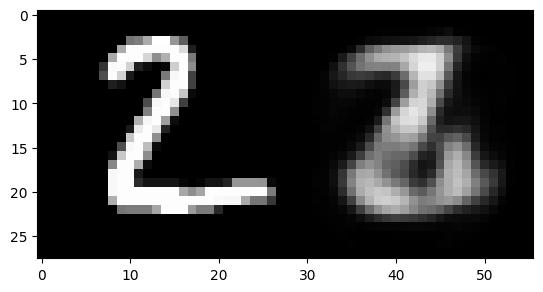

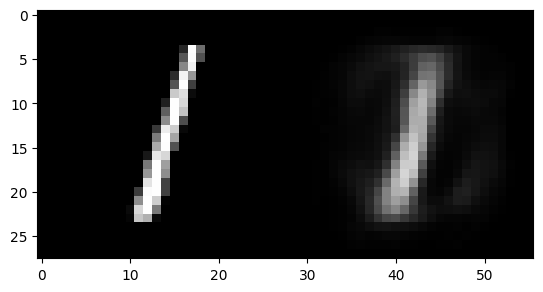

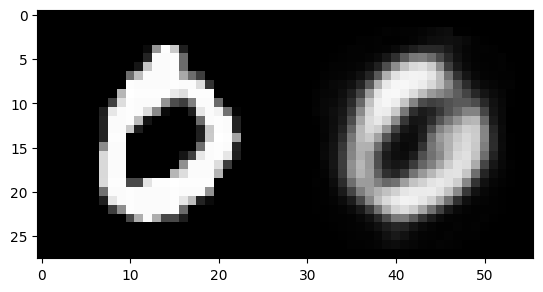

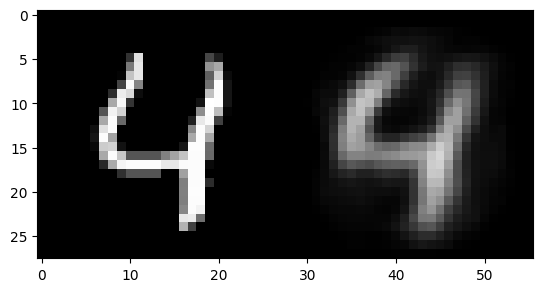

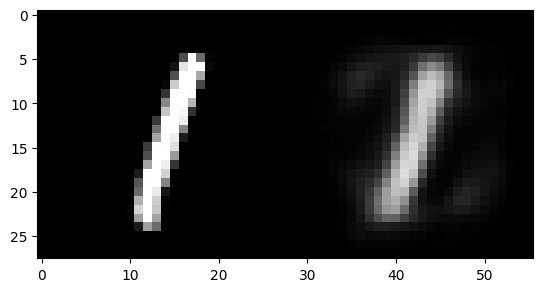

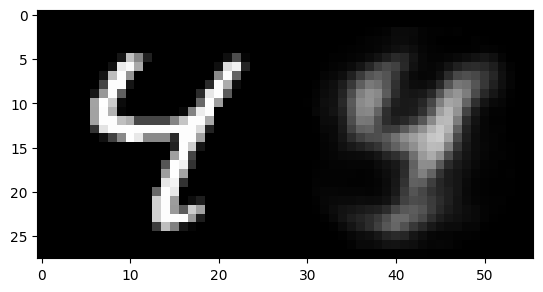

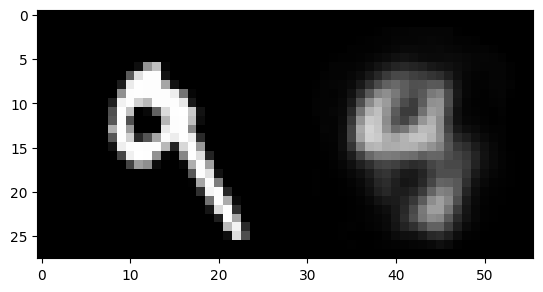

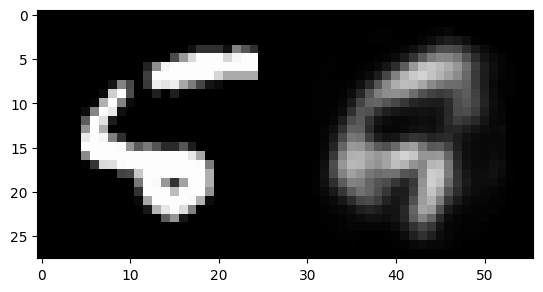

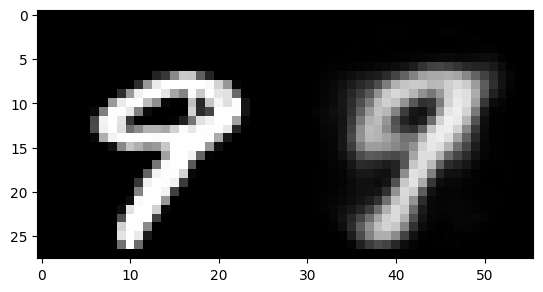

Reconstruct:   0%|          | 0/313 [00:00<?, ?it/s]


In [25]:
def reconstruct(model, test_loader, n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in (pbar := tqdm(test_loader, desc="Reconstruct")):
            images = images.to(device)
            outputs = model(images)
            for i in range(n):
                img = images[i].view(28, 28).cpu().numpy()
                out = outputs[i].view(28, 28).cpu().numpy()
                plt.imshow(np.hstack([img, out]), cmap='gray')
                plt.show()
            break
        
reconstruct(model, test_loader, n = 10)